# Projet d'analyse de fraude

Par Théo DESLAGE et Maximilien GOMAS

## Exploration et visualisation des données

On peut constater que les données sont divisées en deux ensembles :
- Le premier, labelisé, servira à l'apprentissage supervisé (Entrainement et test)
- Le second, inconnu, représente une situation réelle dans laquelle nous devrons prédire à l'aide de notre modèle

Chargeons les données

In [77]:
fraudes <- read.csv("./data/Data_Projet_1.csv", header = TRUE, sep = ",", dec = ".", stringsAsFactors = TRUE)
head(fraudes)

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>
1,54004764,21868593,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
2,33985796,75740424,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
3,53522022,30308357,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
4,13015401,47830476,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
5,22890252,19269962,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No
6,24050443,21831191,36,Male,Other driver error,2116,Auto,No,Injury only,38306.5,3,Yes


Nous allons maintenant explorer les données et comprendre quelles features sont déterminantes pour la prédiction de la fraude.

### Summary pour se donner une vue globale

In [78]:
summary(fraudes)

    claim_id         customer_id            age          gender   
 Min.   :   26832   Min.   :  154557   Min.   :18.0   Female:541  
 1st Qu.:23815805   1st Qu.:26791756   1st Qu.:33.0   Male  :559  
 Median :48539331   Median :49855152   Median :47.0               
 Mean   :48838190   Mean   :50874698   Mean   :47.8               
 3rd Qu.:74074466   3rd Qu.:75949511   3rd Qu.:63.0               
 Max.   :99775483   Max.   :99961993   Max.   :79.0               
            incident_cause days_to_incident  claim_area police_report
 Crime             :110    Min.   :    2.0   Auto:985   No     :630  
 Driver error      :262    1st Qu.:  635.5   Home:115   Unknown:300  
 Natural causes    :189    Median : 2042.5              Yes    :170  
 Other causes      :290    Mean   : 2814.1                           
 Other driver error:249    3rd Qu.: 4153.5                           
                           Max.   :14991.0                           
               claim_type   claim_amount 

In [79]:
table(fraudes$fraudulent)


 No Yes 
846 254 

On se rend compte que les fraudes sont très minoritaires il va donc falloir travailler sur ce dataset

## Pré traitement des données

On sait que deux variables ne sont pas pertinentes dans la prédiction, l'ID de la transaction *claim_id* puisqu'il est unique et le numéro d'utilisateur *customer_id*. On pourrait établir un modèle qui prend en compte le *customer_id* pour "suspecter" ceux qui ont déjà fraudé. Mais dans ce cas de la détection de nouvelles fraudes l'utilisateur sera très probablement nouveau, il ne faut pas que cela altère le jugement du modèle, qui doit se méfier de tout le monde, sans distinction.

In [80]:
# On filtre selon ce qu'on avait décidé sur le claim_amount
fraudes <- fraudes[fraudes$claim_amount<43000,]
# On supprime le claim_id et le customer_id
fraudes <- fraudes[,-c(1:2)]
head(fraudes)

,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>
1,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
2,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
3,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
4,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
5,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No
6,36,Male,Other driver error,2116,Auto,No,Injury only,38306.5,3,Yes


### TEST -> Réduire les transactions non frauduleuses

In [81]:
# cut x rows

dfYes <- fraudes[fraudes$fraudulent=='Yes',]
print(nrow(dfYes))
dfNo <- fraudes[fraudes$fraudulent=='No',]
# Delete some no transactions
dfNo <- tail(dfNo, -550)

# On fusionne les deux dataframes
fraudes <- rbind(dfYes, dfNo)

table(fraudes$fraudulent)


[1] 239



 No Yes 
296 239 

In [83]:
print(nrow(fraudes))

# shuffle to balance fraud yes and no
fraudes <- fraudes[sample(1:nrow(fraudes)),]

print(nrow(fraudes))

[1] 535
[1] 535


## Définition de la méthode d'évaluation des classifieurs

Nous allons utiliser les 3 arbres vus en cours (tree, C5.0 et rpart) et nous allons essayer avec toutes les features, puis seulement avec celles que nous pensons pertinentes.

fraudes -> toutes

fraudesP -> seulement celles pertinentes

## Définition des données d'apprentissage et de test

In [84]:
t <- nrow(fraudes)/3*2
max <- nrow(fraudes)

# (2/3) apprentissage
fraudes_EA <- fraudes[1:375,-1]

# (1/3) test
fraudes_ET <- fraudes[376:535,-1]

table(fraudes_EA$fraudulent)
table(fraudes_ET$fraudulent)


 No Yes 
208 167 


 No Yes 
 88  72 

## Construction et évaluation du classifieur

### Analyse avec toutes les features

In [85]:
library(rpart)
library(C50)
library(tree)
print(nrow(fraudes_EA))

[1] 375


In [86]:
tree1 <- rpart(fraudulent ~ ., fraudes_EA)
tree2 <- C5.0(fraudulent ~ ., fraudes_EA)
tree3 <- tree(fraudulent ~ ., fraudes_EA)

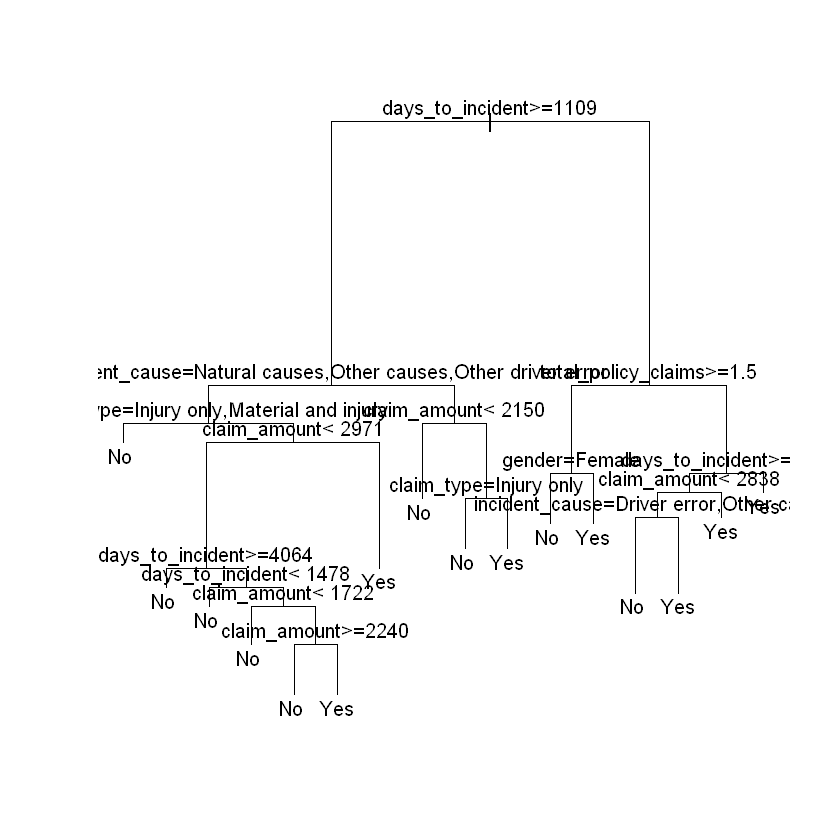

In [87]:
plot(tree1)
text(tree1, pretty=0)

In [92]:
test_tree1 <- predict(tree1, fraudes_ET, type="class")
test_tree2 <- predict(tree2, fraudes_ET, type="class")
test_tree3 <- predict(tree3, fraudes_ET, type="class")

Matrices de confusion

In [93]:
mc_tree1 = table(fraudes_ET$fraudulent, test_tree1)
mc_tree2 = table(fraudes_ET$fraudulent, test_tree2)
mc_tree3 = table(fraudes_ET$fraudulent, test_tree3)
print(mc_tree1)
print(mc_tree2)
print(mc_tree3)

     test_tree1
      No Yes
  No  52  36
  Yes 39  33
     test_tree2
      No Yes
  No  57  31
  Yes 37  35
     test_tree3
      No Yes
  No  57  31
  Yes 38  34


In [94]:
fraudes_ET$Prediction1 <- test_tree1
fraudes_ET$Prediction2 <- test_tree2
fraudes_ET$Prediction3 <- test_tree3

In [95]:
# Success rate

nbr_success <- nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes' & fraudes_ET$Prediction1=='Yes', ])
taux_success1 = nbr_success/nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes',])*100
taux_success1

nbr_success <- nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes' & fraudes_ET$Prediction2=='Yes', ])
taux_success2 = nbr_success/nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes',])*100
taux_success2

nbr_success <- nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes' & fraudes_ET$Prediction3=='Yes', ])
taux_success3 = nbr_success/nrow(fraudes_ET[fraudes_ET$fraudulent=='Yes',])*100
taux_success3

[1] 45.83333

[1] 48.61111

[1] 47.22222

## Choix du classifieur le plus performant

## Application du classifieur aux données à prédire

/!\ Il y a (logiquement) beaucoup plus de No que de Yes, vérifier si on ne doit pas corriger ça (mieux répatir...)